In [1]:
import torch
from torchvision import transforms
from PIL import Image
from fastervit import create_model

# Define fastervit-0 model with 224 x 224 resolution

# Step 1: Load the pre-trained FasterViT model
model = create_model('faster_vit_0_224', 
                          pretrained=True,
                          model_path="tmp/faster_vit_0.pth.tar")
model.eval()

# Inference on Image using pretrained model

In [3]:
# Step 2: Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [4]:

# Step 3: Load and preprocess the image
# Load an image from the local filesystem
image_path = "dog.jpg"
img = Image.open(image_path)

# Apply preprocessing
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

In [5]:
# Step 4: Move the input to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_batch = input_batch.to(device)

In [7]:
# Step 5: Run the model on the image
with torch.no_grad():
    output = model(input_batch)

#output

In [8]:
# Step 6: Post-process the results
# Assuming the output is a classification output with logits for 1000 classes
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the top 5 predictions
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(f"Category ID: {top5_catid[i].item()}, Probability: {top5_prob[i].item()}")

Category ID: 207, Probability: 0.7206041812896729
Category ID: 208, Probability: 0.06556978076696396
Category ID: 852, Probability: 0.005195627920329571
Category ID: 220, Probability: 0.002366974949836731
Category ID: 219, Probability: 0.00217036041431129


## To display the class names instead of the class IDs, you'll need to load the class labels corresponding to the ImageNet dataset

#### 1- Download and Save ImageNet Class Labels

In [9]:
import json
import requests

# Download the class labels from the official source
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(url)
class_names = response.text.splitlines()

# Create a dictionary mapping class IDs to class names
class_idx = {i: class_names[i] for i in range(len(class_names))}

# Save the dictionary as a JSON file
with open("imagenet_class_index.json", "w") as f:
    json.dump(class_idx, f)


In [8]:
import json
# First 5 steps are same. 

# Step 6: Load ImageNet class labels
with open("imagenet_class_index.json") as f:
    idx_to_labels = json.load(f)

#idx_to_labels

In [9]:
# Step 7: Post-process the results
# Assuming the output is a classification output with logits for 1000 classes
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the top 5 predictions
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    class_id = top5_catid[i].item()
    class_name = idx_to_labels[str(class_id)]
    probability = top5_prob[i].item()
    print(f"Class Name: {class_name}, Probability: {probability}")


Class Name: golden retriever, Probability: 0.7206041812896729
Class Name: Labrador retriever, Probability: 0.06556978076696396
Class Name: tennis ball, Probability: 0.005195627920329571
Class Name: Sussex spaniel, Probability: 0.002366974949836731
Class Name: cocker spaniel, Probability: 0.00217036041431129


###### Golden Retriever, Labrador Retriever, Sussex Spaniel, Cocker Spaniel are different breeds of dogs

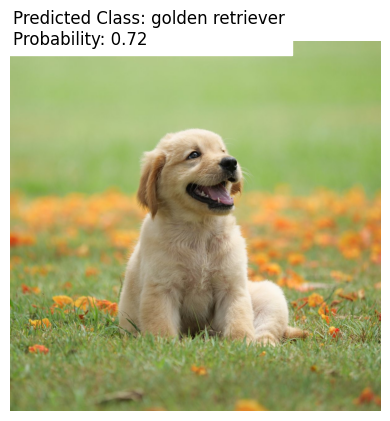

In [11]:
# Step 8: Display the image with predicted class label

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('off')


# # Step 7: Post-process the results
# # Assuming the output is a classification output with logits for 1000 classes
# probabilities = torch.nn.functional.softmax(output[0], dim=0)
# #print(probabilities)

# Get the predicted class
top_prob, top_catid = torch.topk(probabilities, 1)
predicted_class_id = top_catid[0].item()
predicted_class_name = idx_to_labels[str(predicted_class_id)]
probability = top_prob[0].item()
#print(probability)


# Add text with predicted class label
plt.text(10, 10, f'Predicted Class: {predicted_class_name}\nProbability: {probability:.2f}', 
         color='black', backgroundcolor='white', fontsize=12)

plt.show()

## Inference on a video:

In [11]:
import torch
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
from fastervit import create_model
import json
import cv2

# Load FasterViT model
model = create_model('faster_vit_0_224', 
                     pretrained=True,
                     model_path="tmp/faster_vit_0.pth.tar")
model.eval()

# Load ImageNet class labels
with open("imagenet_class_index.json") as f:
    idx_to_labels = json.load(f)

# Open video file
video_path = 'b1.mp4'
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Define output screen size
output_width = 640  # Adjust as needed
output_height = 480  # Adjust as needed

# Step 4: Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Step 5: Process each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame to desired output size
    frame = cv2.resize(frame, (output_width, output_height))

    # Convert frame to PIL Image
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Apply preprocessing
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_batch = input_batch.to(device)

    # Run the model on the input batch
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top_prob, top_catid = torch.topk(probabilities, 1)
    predicted_class_id = top_catid[0].item()
    predicted_class_name = idx_to_labels[str(predicted_class_id)]
    probability = top_prob[0].item()

    # Display the classification result on the frame
    cv2.putText(frame, f'Class: {predicted_class_name}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f'Probability: {probability:.2f}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the frame with classification result
    cv2.imshow('Video Classification', frame)

    # Exit loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture object and close all windows
cap.release()
cv2.destroyAllWindows()
